In [1]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import cftime
import pandas as pd

# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [2]:
#To compute de climatoloy
yearC1='2004'
yearC2='2014'

## Read the data

In [3]:
EN=xr.open_dataset('EN_Global_Jan1950_Dic2023.nc')

In [4]:
EN

<xarray.Dataset> Size: 37GB
Dimensions:      (time: 888, depth: 42, lat: 173, lon: 360)
Coordinates:
  * lon          (lon) float32 1kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * lat          (lat) float32 692B -83.0 -82.0 -81.0 -80.0 ... 87.0 88.0 89.0
  * depth        (depth) float32 168B 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
  * time         (time) datetime64[ns] 7kB 1950-01-16T12:00:00 ... 2023-12-16...
Data variables:
    temperature  (time, depth, lat, lon) float64 19GB ...
    salinity     (time, depth, lat, lon) float64 19GB ...
Attributes:
    description:  EN4

In [5]:
EN_temp=EN.temperature.sel(lat=slice( -60, 60))
EN_salt=EN.salinity.sel(lat=slice( -60, 60))

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [6]:
#Create monthly climatology
EN_temp_clim = EN_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();
EN_salt_clim = EN_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

#Create anomaly
EN_temp_anom = EN_temp.groupby('time.month') - EN_temp_clim
EN_temp_anom.load();

EN_salt_anom = EN_salt.groupby('time.month') - EN_salt_clim
EN_salt_anom.load();

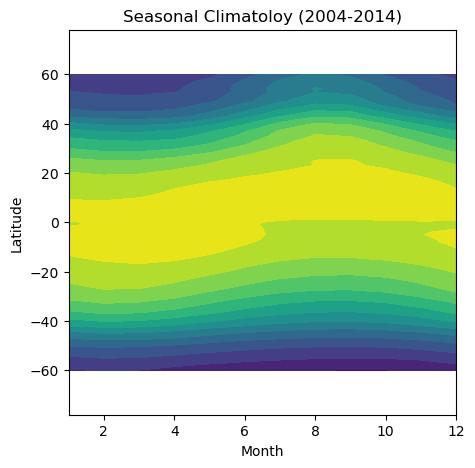

In [7]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(EN_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").month,
                 EN_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").lat,
                 EN_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

# Weighted

In [ ]:
weights = np.cos(np.deg2rad(EN.temperature.lat))
weights = weights/weights.max()
weights.name = "weights"
EN_temp_weighted = EN_temp.weighted(weights)
EN_salt_weighted = EN_salt.weighted(weights)
EN_temp_anom_weighted = EN_temp_anom.weighted(weights)
EN_salt_anom_weighted = EN_salt_anom.weighted(weights)


EN_temp_wmean = EN_temp_weighted.mean(("lon", "lat"),skipna=True).load()
EN_salt_wmean = EN_salt_weighted.mean(("lon", "lat"),skipna=True).load()

EN_temp_anom_wmean = EN_temp_anom_weighted.mean(("lon", "lat"),skipna=True).load()
EN_salt_anom_wmean = EN_salt_anom_weighted.mean(("lon", "lat"),skipna=True).load()

## smoothed versions

In [ ]:
EN_temp_wmean_rolling = EN_temp_wmean.rolling(time=12,center=True).mean()
EN_salt_wmean_rolling = EN_salt_wmean.rolling(time=12,center=True).mean()

EN_temp_anom_wmean_rolling = EN_temp_anom_wmean.rolling(time=12,center=True).mean()
EN_salt_anom_wmean_rolling = EN_salt_anom_wmean.rolling(time=12,center=True).mean()

In [ ]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(EN.time,EN_temp_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(EN.time,EN_temp_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    #ax[i1].xaxis.set_tick_params(labelbottom=False)
    ax[i1].legend();
    i1=i1+1



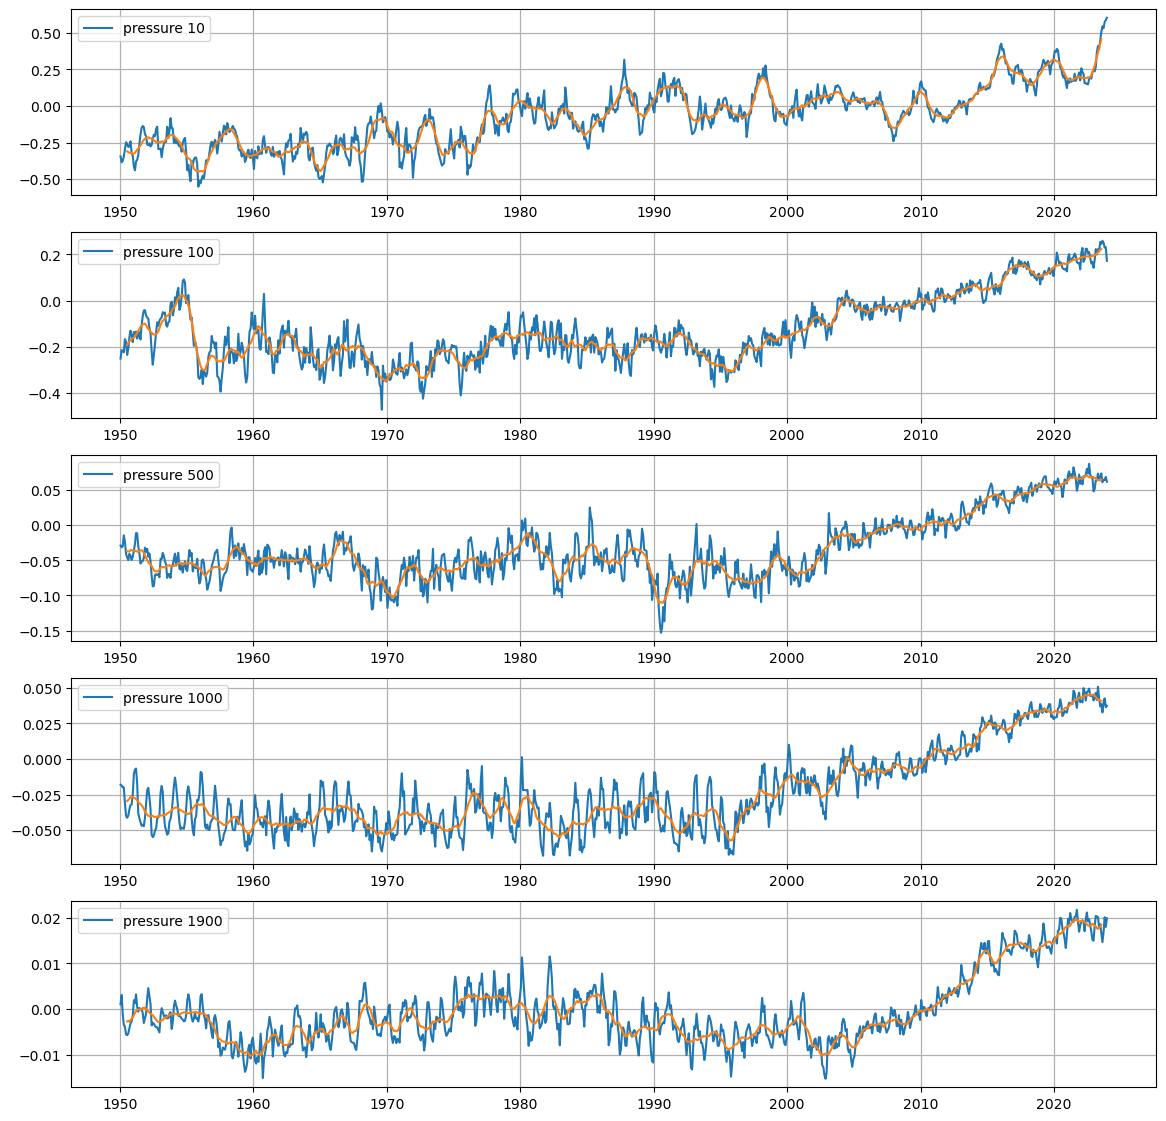

In [14]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(EN.time,EN_temp_anom_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(EN.time,EN_temp_anom_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    #ax[i1].xaxis.set_tick_params(labelbottom=False)
    ax[i1].legend();
    i1=i1+1